In [41]:
import pandas as pd
import numpy as np

# 读取Excel文件
df = pd.read_excel('dict1.xlsx')

# 将DataFrame对象转换为Numpy数组
numpy_array = df.values

# 打印Numpy数组
# print(numpy_array.shape)
X_train = numpy_array[:,0]
Y_train = numpy_array[:,1:]
# X_train.shape

In [43]:
## 插值基向量
# X_basis = X_test
# for i in range(1,84):
#     for j in range(15):
#         a=np.array([i,j*1e-3])
#         X_basis = np.vstack((X_basis, a))
# # print(X_basis)
# for i in range(X_basis.shape[0]):
#     print(X_basis[i])
# print(X_basis.shape)
X_basis=[1]
X_basis=np.array(X_basis)
for i in range(1,84):
    if float(i) not in X_basis and float(i) not in X_train:
        X_basis = np.vstack((X_basis, i))
# X_basis=X_basis.squeeze()

np.save('X_basis.npy',X_basis)
X_basis.shape

(64, 1)

In [44]:
## 高斯过程回归
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

import numpy as np
from sklearn.metrics import mean_squared_error
def calculate_rmse(y_true, y_pred):
    """
    计算两个变量的RMSE
    
    参数:
    y_true -- 真实值，形状为(n_samples,)或(n_samples, 1)
    y_pred -- 预测值，形状为(n_samples,)或(n_samples, 1)
    
    返回:
    rmse -- 均方根误差
    """
    # 确保输入是一维数组
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # 检查长度是否一致
    if len(y_true) != len(y_pred):
        raise ValueError("真实值和预测值的长度必须相同")
    
    # 计算MSE然后取平方根得到RMSE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return rmse

class MultiOutputGPR:
    def __init__(self, kernel=None, n_restarts_optimizer=10, random_state=None):
        self.kernel = kernel
        self.n_restarts_optimizer = n_restarts_optimizer
        self.random_state = random_state
        self.models = []
        self.X_scaler = StandardScaler()
        self.Y_scalers = []
        
    def fit(self, X, Y):
        # 标准化输入
        X_scaled = self.X_scaler.fit_transform(X)
        
        # 为每个输出维度训练一个GPR模型
        n_outputs = Y.shape[1]
        self.models = []
        self.Y_scalers = []
        
        for i in range(n_outputs):
            # 标准化当前输出维度
            y_scaler = StandardScaler()
            y_scaled = y_scaler.fit_transform(Y[:, i].reshape(-1, 1)).flatten()
            self.Y_scalers.append(y_scaler)
            
            # 创建并训练GPR模型
            if self.kernel is None:
                kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0] * X.shape[1], (1e-2, 1e2))
            else:
                kernel = self.kernel
                
            gpr = GaussianProcessRegressor(
                kernel=kernel,
                n_restarts_optimizer=self.n_restarts_optimizer,
                random_state=self.random_state
            )
            
            gpr.fit(X_scaled, y_scaled)
            self.models.append(gpr)
            
        return self
    
    def predict(self, X, return_std=False):
        X_scaled = self.X_scaler.transform(X)
        n_outputs = len(self.models)
        
        if return_std:
            y_pred = np.zeros((X.shape[0], n_outputs))
            y_std = np.zeros((X.shape[0], n_outputs))
            
            for i, (model, scaler) in enumerate(zip(self.models, self.Y_scalers)):
                pred, std = model.predict(X_scaled, return_std=True)
                y_pred[:, i] = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
                y_std[:, i] = std * scaler.scale_  # 调整标准差
                
            return y_pred, y_std
        else:
            y_pred = np.zeros((X.shape[0], n_outputs))
            
            for i, (model, scaler) in enumerate(zip(self.models, self.Y_scalers)):
                pred = model.predict(X_scaled)
                y_pred[:, i] = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
                
            return y_pred

# 使用自定义类
np.random.seed(42)

# 输入数据 (4, 2)
# X = np.random.randn(4, 2)
X=X_train.reshape(-1,1)
X.shape
# 输出数据 (4, 21)
Y = Y_train #np.random.randn(4, 21)

# 创建并训练模型
multi_gpr = MultiOutputGPR(n_restarts_optimizer=10, random_state=42)
multi_gpr.fit(X, Y)
        
Y_pred_gau, Y_std = multi_gpr.predict(X_basis, return_std=True)
print(Y_pred_gau.shape)

/home/gnn/miniconda3/envs/c3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(64, 7)


In [45]:
from sklearn.ensemble import RandomForestClassifier  # 分类
from sklearn.ensemble import RandomForestRegressor   # 回归
import pandas as pd
import numpy as np

model = RandomForestRegressor(n_estimators=100, random_state=42)   # 对于回归

import numpy as np
from sklearn.metrics import mean_squared_error
def calculate_rmse(y_true, y_pred):
    """
    计算两个变量的RMSE
    
    参数:
    y_true -- 真实值，形状为(n_samples,)或(n_samples, 1)
    y_pred -- 预测值，形状为(n_samples,)或(n_samples, 1)
    
    返回:
    rmse -- 均方根误差
    """
    # 确保输入是一维数组
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # 检查长度是否一致
    if len(y_true) != len(y_pred):
        raise ValueError("真实值和预测值的长度必须相同")
    
    # 计算MSE然后取平方根得到RMSE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return rmse

model.fit(X_train.reshape(-1,1), Y_train)  # X_train 是训练特征，y_train 是训练标签
Y_pred_ran = model.predict(X_basis)  # X_test 是测试特征
print(Y_pred_ran.shape)

(64, 7)


In [46]:
import numpy as np
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 生成示例数据
# n_samples = 4
# input_dim = 2
# output_dim = 21

# 输入数据 (4, 2)
# X = np.random.randn(n_samples, input_dim)
X=X_train.shape(-1,1)

# 输出数据 (4, 21) - 假设输出与输入有某种关系
# Y = np.zeros((n_samples, output_dim))
Y=Y_train

# for i in range(y_train.shape[-1]):
#     # 每个输出维度都是输入的线性组合加上一些噪声
#     weights = np.random.randn(X.shape[1])
#     bias = np.random.randn()
#     Y[:, i] = np.dot(X, weights) + bias + 0.1 * np.random.randn(X.shape[0])
# 数据标准化
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# 划分训练集和测试集
# 由于数据量很小，我们使用所有数据作为训练集，并创建一些测试数据
X_train, Y_train = X_scaled, Y_scaled

# 创建测试数据
X_test = X_basis #np.random.randn(3, input_dim)
X_test_scaled = scaler_X.transform(X_basis)

# 创建XGBoost模型
# 使用MultiOutputRegressor包装器处理多维输出
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

multioutput_model = MultiOutputRegressor(xgb_model)

# 训练模型
multioutput_model.fit(X_train, Y_train)

# 预测
Y_pred_scaled = multioutput_model.predict(X_test_scaled)
Y_pred_xgb = scaler_Y.inverse_transform(Y_pred_scaled)
print(Y_pred_xgb.shape)

TypeError: 'tuple' object is not callable

In [ ]:
# Y_train_MLP = (Y_pred_xgb+Y_pred_ran+Y_pred_gau)/3
Y_train_MLP = (Y_pred_ran+Y_pred_gau)/2

np.save('temp_.npy',Y_train_MLP)
Y_train_MLP.shape


(64, 7)

/home/xzw/miniconda3/envs/torch11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [500/3000], Loss: 0.108020
Epoch [1000/3000], Loss: 0.093423
早停在 epoch 1480


/tmp/ipykernel_4062112/333933936.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


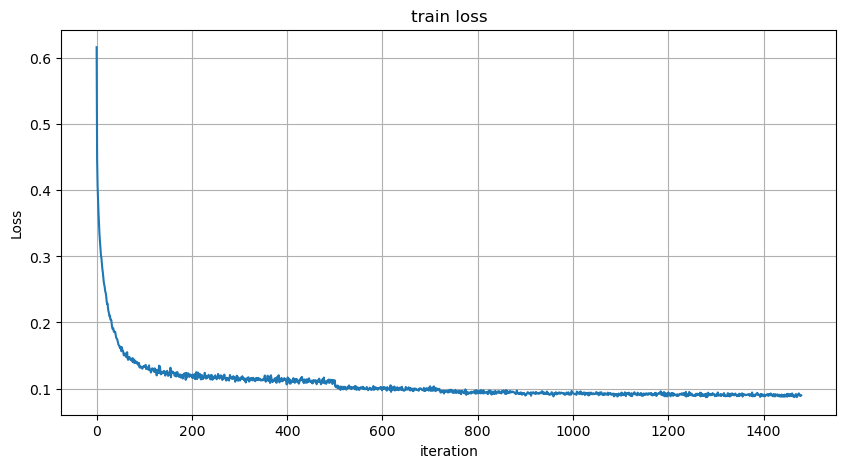

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 生成示例数据
# n_samples = 4
# input_dim = 2
# output_dim = 21
bs_size = 32

X =  X_basis # np.random.randn(n_samples, input_dim)
Y = Y_train_MLP #np.zeros((n_samples, output_dim))
# for i in range(y_train.shape[-1]):
#     # 每个输出维度都是输入的线性组合加上一些噪声
#     weights = np.random.randn(X.shape[1])
#     bias = np.random.randn()
#     Y[:, i] = np.dot(X, weights) + bias + 0.1 * np.random.randn(X.shape[0])

# for i in range(output_dim):
#     weights = np.random.randn(input_dim)
#     bias = np.random.randn()
#     Y[:, i] = np.dot(X, weights) + bias + 0.1 * np.random.randn(n_samples)

# 数据标准化
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X_scaled).to(device)
Y_tensor = torch.FloatTensor(Y_scaled).to(device)

# 创建数据集和数据加载器
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=bs_size, shuffle=True)

# 定义更复杂的MLP模型
class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvancedMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)

# 创建模型实例
model = AdvancedMLP(X.shape[-1], y_train.shape[-1]).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 添加学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=100, verbose=True
)

# 早停设置
best_loss = float('inf')
patience = 200
patience_counter = 0

# 训练模型
num_epochs = 3000
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    
    for batch_X, batch_Y in dataloader:
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_epoch_loss)
    
    # 更新学习率
    scheduler.step(avg_epoch_loss)
    
    # 早停检查
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"早停在 epoch {epoch+1}")
        break
    
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}')

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 绘制训练损失
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('train loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 预测
model.eval()
with torch.no_grad():
    # X_test = np.random.randn(3, input_dim)

    X_test_scaled = scaler_X.transform(X_test)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    
    Y_pred_scaled = model(X_test_tensor).cpu().numpy()
    Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
    if X_test_tensor[0]==51.0:
        print(Y_pred.shape)

print("预测结果=:", Y_pred[:,-2:])
print("预测误差:")

import torch.nn as nn

print(np.sqrt(nn.MSELoss(reduction="mean")(torch.FloatTensor(Y_pred[:,-2:]), torch.FloatTensor(y_test[:,-2:]))))
